# Initialization

In [29]:
#cd ../AN2DL_Challenges/Challenge_1/

#Loading dependencies

In [30]:

import tensorflow as tf 
import numpy as np
import os
import random
from PIL import Image # A computer vision library
import h5py
import psutil
import tqdm
import imutils
import scipy
import cv2
import yaml
import skimage
import sklearn
import Cython
import seaborn 
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


### Import libraries


Libraries installed in the evaluation machine:

    tensorflow==2.10.0 x
    Cython==0.29.32 
    numpy==1.21.6 x
    matplotlib==3.2.2
    seaborn==0.11.2
    scipy==1.7.3
    scikit-learn==1.0.2
    scikit-image==0.18.3
    pandas==1.3.5 x
    pyyaml==6.0
    imutils==0.5.4
    opencv-python==4.6.0.66
    tqdm==4.64.1
    psutil==5.4.8
    h5py==3.1.0


In [31]:
# Install and import visualkeras library
# ---> CAN'T BE USED IN THE FINAL SUBMIT
import visualkeras

### Set seed for reproducibility

In [32]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [33]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Plants dataset

Pictures of different kinds of plants.

Class labels:
1. "Species1"
2. "Species2"
3. "Species3"
4. "Species4"
5. "Species5"
6. "Species6"
7. "Species7"
8. "Species8"

In [34]:
#import splitfolders
# Dataset folder
#dataset_dir = 'training_data'

In [35]:
#splitfolders.ratio(dataset_dir, output="dataset", seed=seed, ratio=(.8,.1,.1), group_prefix=None, move=True)

In [36]:
dataset_dir = 'dataset'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

StopIteration: 

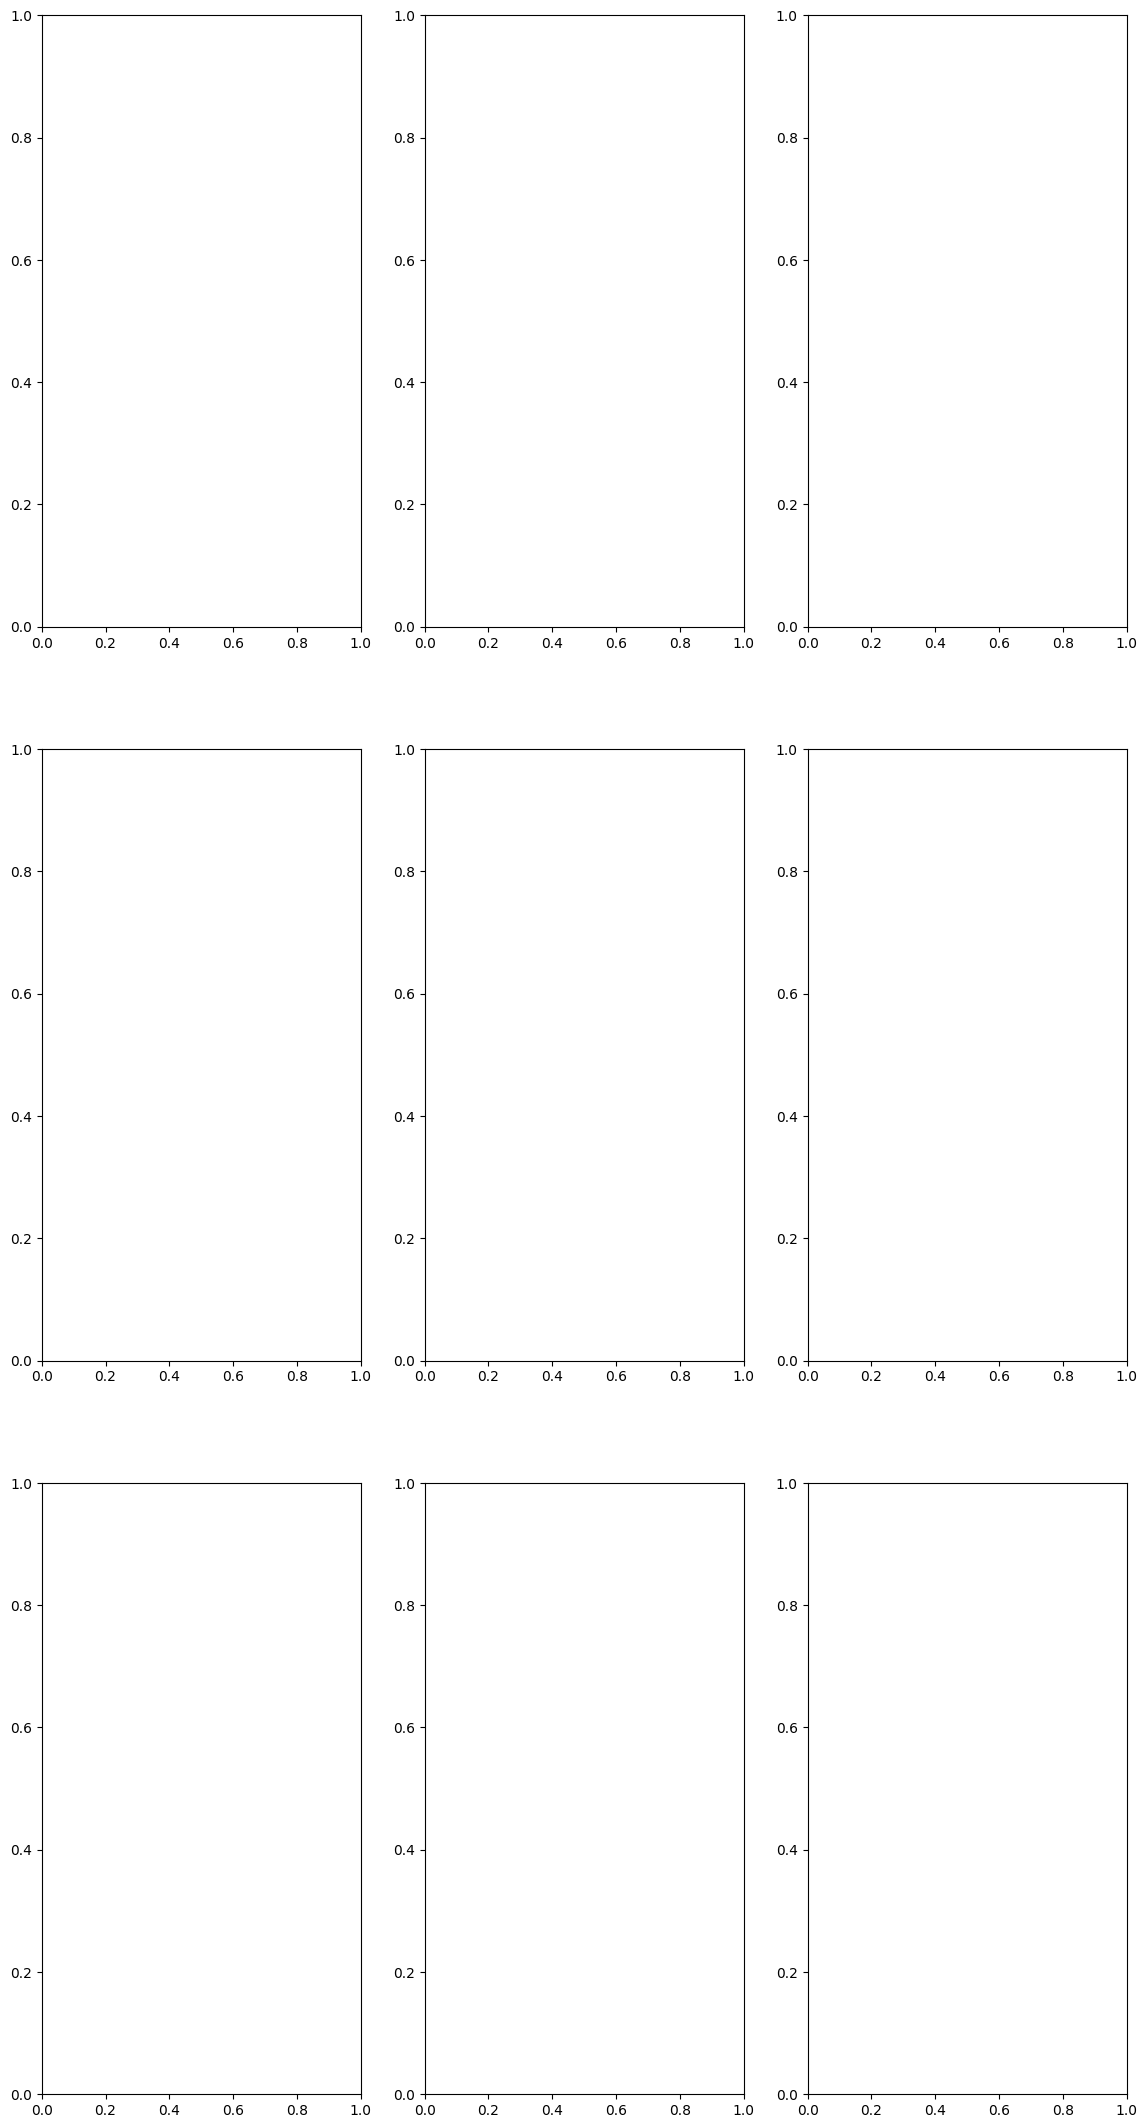

In [37]:
# Plot example images from dataset
labels = [
          'Species1',   # 0
          'Species2',   # 1
          'Species3',   # 2
          'Species4',   # 3
          'Species5',   # 4
          'Species6',   # 5
          'Species7',   # 6
          'Species8',   # 7
          ]

num_row = 7
num_col = 3
fig, axes = plt.subplots(3, 3, figsize=(2*num_row,9*num_col))
for i in range(8):
  if i < 8:
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [ ]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()
test_data_gen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)
valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)
test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(96,96),
                                              color_mode='rgb',
                                              classes=None, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

FileNotFoundError: [WinError 3] Impossibile trovare il percorso specificato: 'dataset\\train'

In [ ]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}

Target classes
[0 0 0 ... 7 7 7]


Set is divided into batches:
# What is a batch ?
The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.

Think of a batch as a for-loop iterating over one or more samples and making predictions. At the end of the batch, the predictions are compared to the expected output variables and an error is calculated. From this error, the update algorithm is used to improve the model, e.g. move down along the error gradient.

A training dataset can be divided into one or more batches.

In [ ]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (8, 96, 96, 3)
Target shape: (8, 8)

Categorical label: [0. 0. 0. 1. 0. 0. 0. 0.]
Label: 3
Class name: Species4


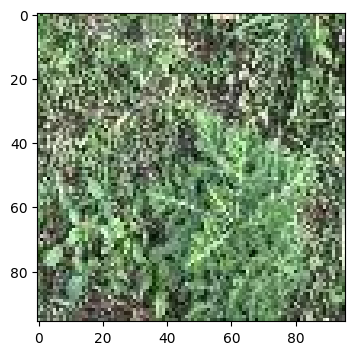

In [ ]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

# Training WITHOUT data augmentation

In [ ]:
# Create an instance of ImageDataGenerator with NO Data Augmentation
train_data_gen = ImageDataGenerator(rescale=1/96.) # rescale value is multiplied to the image
valid_data_gen = ImageDataGenerator(rescale=1/96.)
test_data_gen = ImageDataGenerator(rescale=1/96.)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                                           target_size=(96,96),
                                                           color_mode='rgb',
                                                           classes=None, # can be set to labels
                                                           class_mode='categorical',
                                                           batch_size=8,
                                                           shuffle=True,
                                                           seed=seed)
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=8,
                                             shuffle=False,
                                             seed=seed)

Found 2829 images belonging to 8 classes.
Found 351 images belonging to 8 classes.
Found 362 images belonging to 8 classes.


### Models metadata

In [ ]:
input_shape = (96, 96, 3)
epochs = 100

### CNN model

In [ ]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D()(conv1)

    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D()(conv2)

    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D()(conv3)

    conv4 = tfkl.Conv2D(
        filters=256,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D()(conv4)

    conv5 = tfkl.Conv2D(
        filters=512,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D()(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    dropout = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu')(dropout)
    dropout = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
# Download and import visualkeras library
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 128)       73856 

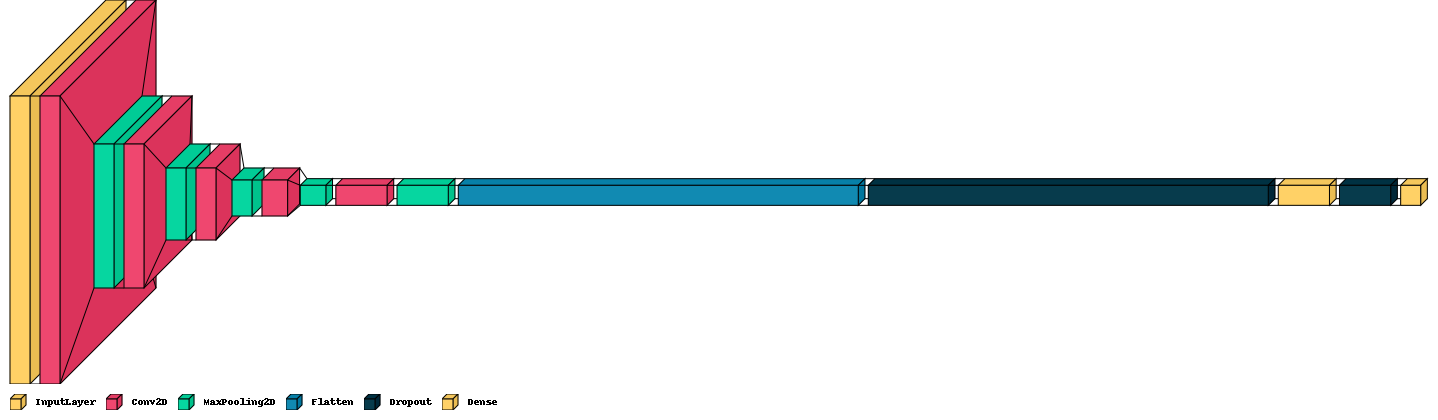

In [ ]:
# Build model (for NO augmentation training)
model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=10, scale_xy=3)

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
# Create folders and callbacks and fit
noaug_callbacks = create_folders_and_callbacks(model_name='CNN_NoAug')

# Train the model
history = model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = noaug_callbacks,
).history

Epoch 1/100
354/354 [==============================] - 4s 11ms/step - loss: 0.8055 - accuracy: 0.7112 - val_loss: 1.3631 - val_accuracy: 0.5299
Epoch 2/100
354/354 [==============================] - 4s 10ms/step - loss: 0.7237 - accuracy: 0.7367 - val_loss: 1.4988 - val_accuracy: 0.5214
Epoch 3/100
354/354 [==============================] - 3s 9ms/step - loss: 0.6112 - accuracy: 0.7872 - val_loss: 1.3577 - val_accuracy: 0.5926
Epoch 4/100
354/354 [==============================] - 3s 9ms/step - loss: 0.5113 - accuracy: 0.8066 - val_loss: 1.4428 - val_accuracy: 0.5584
Epoch 5/100
354/354 [==============================] - 3s 9ms/step - loss: 0.4037 - accuracy: 0.8544 - val_loss: 1.6725 - val_accuracy: 0.5442
Epoch 6/100
354/354 [==============================] - 3s 9ms/step - loss: 0.3805 - accuracy: 0.8738 - val_loss: 1.7174 - val_accuracy: 0.5527
Epoch 7/100
354/354 [==============================] - 3s 9ms/step - loss: 0.3105 - accuracy: 0.8950 - val_loss: 1.8961 - val_accuracy: 0.56

In [ ]:
# Save best epoch model
model.save("data_augmentation_experiments/CNN_NoAug_Best")

In [ ]:
# Evaluate on test
# Trainined with no data augmentation
model_noaug = tfk.models.load_model("data_augmentation_experiments/CNN_NoAug_Best")
model_noaug_test_metrics = model_noaug.evaluate(test_gen, return_dict=True)
# Trained with data augmentation
# model_aug = tfk.models.load_model("data_augmentation_experiments/CNN_Aug_Best")
# model_aug_test_metrics = model_aug.evaluate(test_gen, return_dict=True)

print()
print("Test metrics without data augmentation")
print(model_noaug_test_metrics)
# print("Test metrics with data augmentation")
# print(model_aug_test_metrics)

46/46 [==============================] - 0s 5ms/step - loss: 1.3824 - accuracy: 0.5691

Test metrics without data augmentation
{'loss': 1.3823801279067993, 'accuracy': 0.5690608024597168}
